Lesson 2 - Applied Regression Modeling - Diagnostics for Straight Line Regression

In [1]:
import pandas as pd
import tabula
import numpy as np
import random
import os

from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Diagnostics for Straight Line Regression

###### - In Lesson 2 we saw that when we use a regression model, we implicitly make a series of assumptions.
- In Lesson 3 we consider a series of tools known as regression diagnostics to check each assumption. 
- A primary aim of Lesson 3 is to understand what actually happens when the standard assumptions associated with a regression model are violated, and what should be done in response to each violation.

# Attribution/ Citations
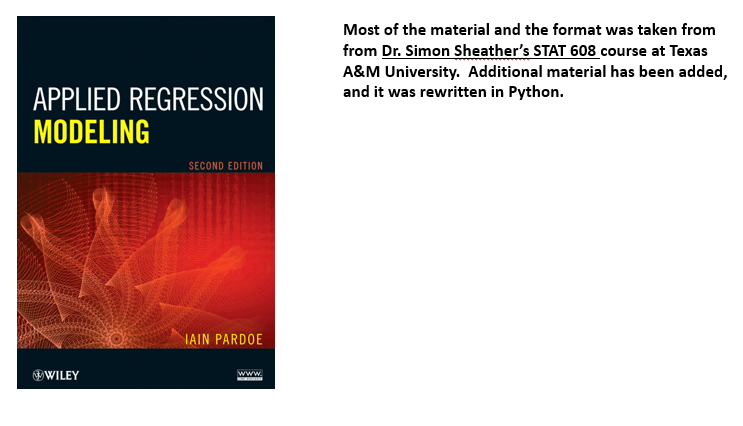

<b>ATTRIBUTION/ CITATION:</b> Most of this material including the course outline was taken from Dr. Simon Sheather's STAT 608 course at Texas A&M University. However, it uses additional examples and was adopted for use with Python. In addition, much of the course material used the textbook Applied Regression Modeling by Iain Pardoe. 

# Functions

In [2]:
def get_anscombs_data(save_to_pickle = True):
    
    anscombs = pd.read_html('https://en.wikipedia.org/wiki/Anscombe%27s_quartet#cite_note-2')[1].iloc[1:]
    anscombs = anscombs.rename(columns = {'I':'x1','I.1':'y1', 'II':'x2','II.1':'y2','III':'x3','III.1':'y3','IV':'x4','IV.1':'y4'})
    anscombs = anscombs[['x1','x2','x3','x4','y1','y2','y3','y4']]
    anscombs = anscombs.astype(float)

    if save_to_pickle:
        
        # Save as a pickle file
        anscombs.to_pickle('./anscombs.pkl')
    
    return  anscombs

In [3]:
def get_football_attendance_data(save_to_pickle = True):
    
    path_2014 = 'http://fs.ncaa.org/Docs/stats/football_records/Attendance/2014.pdf'
    path_2015 = 'http://fs.ncaa.org/Docs/stats/football_records/Attendance/2015.pdf'

    football_stats_2014 = tabula.read_pdf(path_2014, pages = (7,8), pandas_options={'header': None})
    football_stats_2015 = tabula.read_pdf(path_2015, pages = (7,8), pandas_options={'header': None})
    
    # Munge 2014 Football Data
    table1 = football_stats_2014[0].iloc[:,0:4].rename(columns={0: 'School', 1: '2014 Home Games', 2:'2014 Attendance', 3: '2014 Average Attendance'})
    table2 = football_stats_2014[0].iloc[:,4:8].rename(columns={4: 'School', 5: '2014 Home Games', 6:'2014 Attendance', 7: '2014 Average Attendance'})
    table3 = football_stats_2014[1].iloc[0:9,0:3].rename(columns={0: 'School', 1:'2014 Attendance', 2: '2014 Average Attendance'})
    #table3[['School', '2014 Home Games']] = football_stats_2014['School'].str.extract(r'(.*?)\s+([A-Z]{1,}\d{3,})?$', expand=True)

    # Split the number of home games from the name column
    table3['2014 Home Games'] = table3['School'].str.rsplit(' ', n = 1, expand = True)[1] 
    table3['School'] = table3['School'].str.rsplit(' ', n = 1, expand = True)[0] 
    table4 = football_stats_2014[1].iloc[0:8,3:7].rename(columns={3: 'School', 4: '2014 Home Games', 5:'2014 Attendance', 6: '2014 Average Attendance'})

    football_2014 = pd.concat([table1,table2, table3, table4]).sort_values('School').reset_index().drop(columns = 'index')

    # Munge 205 Football Data
    table1 = football_stats_2015[0].iloc[:,0:4].rename(columns={0: 'School', 1: '2015 Home Games', 2:'2015 Attendance', 3: '2015 Average Attendance'})
    table2 = football_stats_2015[0].iloc[:,4:8].rename(columns={4: 'School', 5: '2015 Home Games', 6:'2015 Attendance', 7: '2015 Average Attendance'})
    table3 = football_stats_2015[1].iloc[0:9,0:3].rename(columns={0: 'School', 1:'2015 Attendance', 2: '2015 Average Attendance'})

    # split the number of home games from the name column
    table3['2015 Home Games'] = table3['School'].str.rsplit(' ', n = 1, expand = True)[1] 
    table3['School'] = table3['School'].str.rsplit(' ', n = 1, expand = True)[0] 
    table4 = football_stats_2015[1].iloc[0:8,3:7].rename(columns={3: 'School', 4: '2015 Home Games', 5:'2015 Attendance', 6: '2015 Average Attendance'})

    football_2015 = pd.concat([table1,table2, table3, table4]).sort_values('School').reset_index().drop(columns = 'index')

    # Merge the data sets
    football_stats = football_2014.merge(football_2015, left_on='School', right_on = 'School')

    # Remove the comma delimitted values in the columns and convert to integer values
    football_stats['2014 Average Attendance'] = football_stats['2014 Average Attendance'].str.replace(',', '')
    football_stats['2014 Attendance'] = football_stats['2014 Attendance'].str.replace(',', '')
    football_stats['2015 Average Attendance'] = football_stats['2015 Average Attendance'].str.replace(',', '')
    football_stats['2015 Attendance'] = football_stats['2015 Attendance'].str.replace(',', '')

    # Make all values of type int
    football_stats = football_stats.astype({'2014 Average Attendance':int,
                                            '2014 Attendance': int,
                                            '2014 Home Games': int, 
                                            '2015 Home Games': int, 
                                            '2015 Attendance': int,
                                            '2015 Average Attendance': int})

    if save_to_pickle:
        
        # Save as a pickle file
        football_stats.to_pickle('./football_stats.pkl')
    
    return football_stats


# Get the data
The data consist of average attendance figures at home games of college football in 2014 and 2015

In [4]:
if os.path.exists('./anscombs.pkl'):
    anscombs = pd.read_pickle('./anscombs.pkl')
    print("Yay! It's there!")

else:
    anscombs = get_anscombs_data()
print('Length of the dataset is ', len(anscombs))
anscombs.head(10)

Yay! It's there!
Length of the dataset is  11


,x1,x2,x3,x4,y1,y2,y3,y4
1,10.0,10.0,10.0,8.0,8.04,9.14,7.46,6.58
2,8.0,8.0,8.0,8.0,6.95,8.14,6.77,5.76
3,13.0,13.0,13.0,8.0,7.58,8.74,12.74,7.71
4,9.0,9.0,9.0,8.0,8.81,8.77,7.11,8.84
5,11.0,11.0,11.0,8.0,8.33,9.26,7.81,8.47
6,14.0,14.0,14.0,8.0,9.96,8.10,8.84,7.04
7,6.0,6.0,6.0,8.0,7.24,6.13,6.08,5.25
8,4.0,4.0,4.0,19.0,4.26,3.10,5.39,12.50
9,12.0,12.0,12.0,8.0,10.84,9.13,8.15,5.56
10,7.0,7.0,7.0,8.0,4.82,7.26,6.42,7.91


# Anscomb's 4 data sets
This constructed example illustrates dramatically the point that looking only at the
numerical regression output may lead to very misleading conclusions about the data,
and lead to adopting the wrong model. Notice that the Y‐values differ in each of the
four data sets, while the X‐values are the same for data sets 1, 2 and 3.

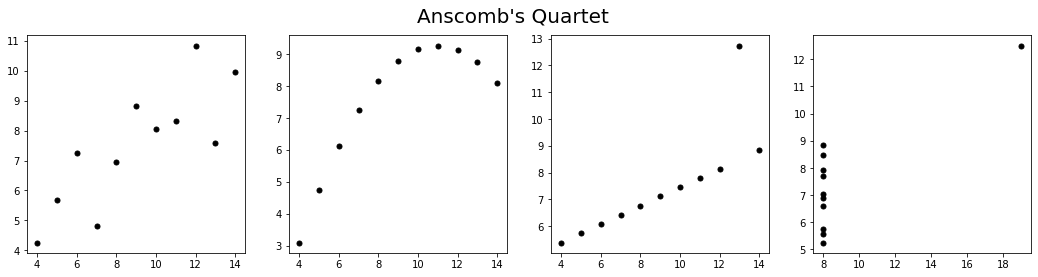

In [5]:
fig = plt.figure(figsize = (18,4))

ax1 = plt.subplot2grid((1, 4), (0, 0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((1, 4), (0, 1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((1, 4), (0, 2), rowspan=1, colspan=1)
ax4 = plt.subplot2grid((1, 4), (0, 3), rowspan=1, colspan=1)

ax1.scatter(anscombs['x1'], anscombs['y1'], color = 'black', s = 25)
ax2.scatter(anscombs['x2'], anscombs['y2'], color = 'black', s = 25)
ax3.scatter(anscombs['x3'], anscombs['y3'], color = 'black', s = 25)
ax4.scatter(anscombs['x4'], anscombs['y4'], color = 'black', s = 25)

plt.suptitle("Anscomb's Quartet", fontsize = 20)
plt.show()

In [6]:
anscombs

,x1,x2,x3,x4,y1,y2,y3,y4
1,10.0,10.0,10.0,8.0,8.04,9.14,7.46,6.58
2,8.0,8.0,8.0,8.0,6.95,8.14,6.77,5.76
3,13.0,13.0,13.0,8.0,7.58,8.74,12.74,7.71
4,9.0,9.0,9.0,8.0,8.81,8.77,7.11,8.84
5,11.0,11.0,11.0,8.0,8.33,9.26,7.81,8.47
6,14.0,14.0,14.0,8.0,9.96,8.10,8.84,7.04
7,6.0,6.0,6.0,8.0,7.24,6.13,6.08,5.25
8,4.0,4.0,4.0,19.0,4.26,3.10,5.39,12.50
9,12.0,12.0,12.0,8.0,10.84,9.13,8.15,5.56
10,7.0,7.0,7.0,8.0,4.82,7.26,6.42,7.91


In [7]:
# import library and select data to model
import statsmodels.api as sm

df = anscombs.copy()

In [8]:
#set x and y variables and type cast them as float variables

x1, x2, x3, x4 = df['x1'].astype(float), df['x2'].astype(float), df['x3'].astype(float), df['x4'].astype(float)
y1, y2, y3, y4 = df['y1'].astype(float), df['y2'].astype(float), df['y3'].astype(float), df['y4'].astype(float)

In [9]:
# in StatsModels you have to add a constant for the intercept

x1 = sm.add_constant(x1) 
x2 = sm.add_constant(x2) 
x3 = sm.add_constant(x3) 
x4 = sm.add_constant(x4) 

In [10]:
# declare the models

model1 = sm.OLS(y1, x1)
model2 = sm.OLS(y2, x2)
model3 = sm.OLS(y3, x3)
model4 = sm.OLS(y4, x4)

In [11]:
# fit the models

fit1 = model1.fit()
fit2 = model2.fit()
fit3 = model3.fit()
fit4 = model4.fit()

In [12]:
# make predictions (yhat) for each dataset

yhat1 = fit1.predict(x1)
yhat2 = fit2.predict(x2)
yhat3 = fit3.predict(x3)
yhat4 = fit4.predict(x4)

In [13]:
# add predictions back to the dataframe

df['yhat1'] = yhat1
df['yhat2'] = yhat2
df['yhat3'] = yhat3
df['yhat4'] = yhat4

In [14]:
# add the values back to the original dataframe

anscombs = df.copy()

## Anscomb's Fit Statistics
Notice that every number from the fit statistics in the 4 sets of output matches to at least 2 decimal places!

- Coeff
- Standard Error
- t stat
- p value
- Confidence Intervals
- R - squared
- Adjusted R squared



In [15]:
# print the model summary
print('\n------------------------------\nData Set 1\n------------------------------\n',fit1.summary())
print('\n------------------------------\nData Set 2\n------------------------------\n',fit2.summary())
print('\n------------------------------\nData Set 3\n------------------------------\n',fit3.summary())
print('\n------------------------------\nData Set 4\n------------------------------\n',fit4.summary())


------------------------------
Data Set 1
------------------------------
                             OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     17.99
Date:                Tue, 08 Sep 2020   Prob (F-statistic):            0.00217
Time:                        09:16:20   Log-Likelihood:                -16.841
No. Observations:                  11   AIC:                             37.68
Df Residuals:                       9   BIC:                             38.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

# Anscombs Fit Graphically

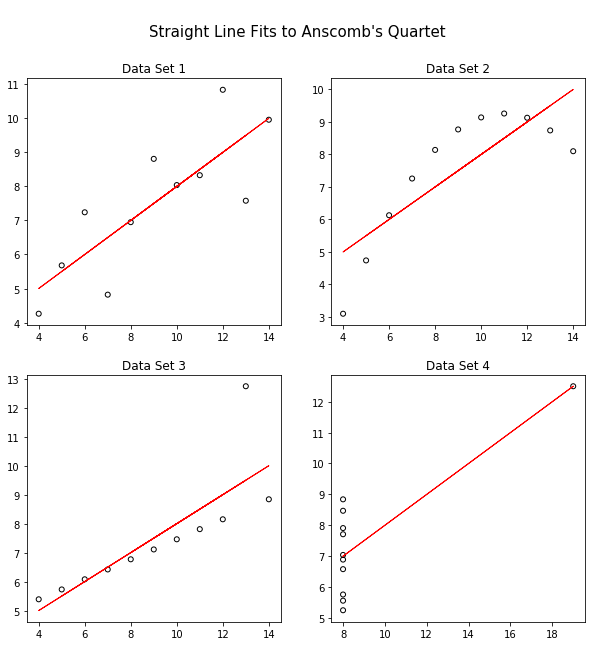

In [16]:
fig = plt.figure(figsize = (10,10))

ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 0), rowspan=1, colspan=1)
ax4 = plt.subplot2grid((2, 2), (1, 1), rowspan=1, colspan=1)

ax1.scatter(anscombs['x1'], anscombs['y1'], color = 'black', s = 25, facecolors='none', edgecolors='black')
ax1.plot(anscombs['x1'], anscombs['yhat1'], color = 'red', linewidth = 1)
ax1.set_title('Data Set 1')

ax2.scatter(anscombs['x2'], anscombs['y2'], color = 'black', s = 25, facecolors='none', edgecolors='black')
ax2.plot(anscombs['x2'], anscombs['yhat2'], color = 'red', linewidth = 1)
ax2.set_title('Data Set 2')

ax3.scatter(anscombs['x3'], anscombs['y3'], color = 'black', s = 25, facecolors='none', edgecolors='black')
ax3.plot(anscombs['x3'], anscombs['yhat3'], color = 'red', linewidth = 1)
ax3.set_title('Data Set 3')

ax4.scatter(anscombs['x4'], anscombs['y4'], color = 'black', s = 25, facecolors='none', edgecolors='black')
ax4.plot(anscombs['x4'], anscombs['yhat4'], color = 'red', linewidth = 1)
ax4.set_title('Data Set 4')

plt.suptitle("\nStraight Line Fits to Anscomb's Quartet", fontsize = 15)
plt.show()


### Anscomb's Strait Line Fits
<b>A straight‐line regression model is appropriate only for Data Set 1.</b> On the other hand, the
data in Data Set 2 seem to have a curved rather than a straight‐line relationship. The third
data set has an extreme outlier that should be investigated. For the fourth data set, the
slope of the regression line is solely determined by a single point, namely, the point with
the largest x‐value.
<b>This is why we make residual plots and examine the data graphically</b>

# Residuals from straight line fits to Anscombe’s data 

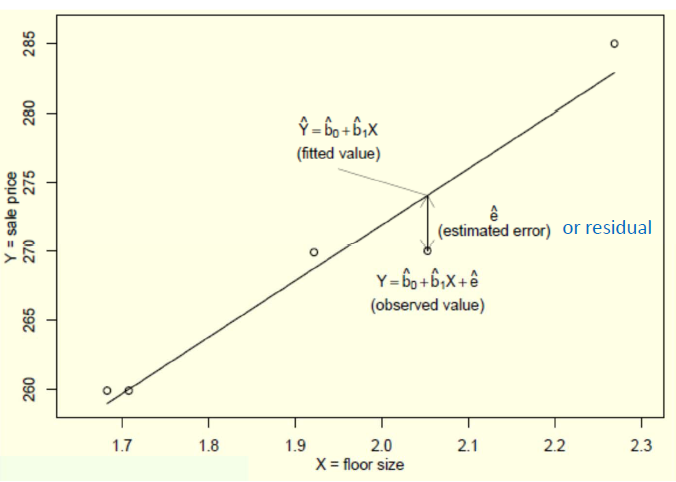

In [17]:
# Calculate the residuals....
anscombs['residuals1'] = anscombs['y1']-anscombs['yhat1']
anscombs['residuals2'] = anscombs['y2']-anscombs['yhat2']
anscombs['residuals3'] = anscombs['y3']-anscombs['yhat3']
anscombs['residuals4'] = anscombs['y4']-anscombs['yhat4']
anscombs

,x1,x2,x3,x4,y1,y2,y3,y4,yhat1,yhat2,yhat3,yhat4,residuals1,residuals2,residuals3,residuals4
1,10.0,10.0,10.0,8.0,8.04,9.14,7.46,6.58,8.001000,8.000909,7.999727,7.001,0.039000,1.139091,-0.539727,-0.421
2,8.0,8.0,8.0,8.0,6.95,8.14,6.77,5.76,7.000818,7.000909,7.000273,7.001,-0.050818,1.139091,-0.230273,-1.241
3,13.0,13.0,13.0,8.0,7.58,8.74,12.74,7.71,9.501273,9.500909,9.498909,7.001,-1.921273,-0.760909,3.241091,0.709
4,9.0,9.0,9.0,8.0,8.81,8.77,7.11,8.84,7.500909,7.500909,7.500000,7.001,1.309091,1.269091,-0.390000,1.839
5,11.0,11.0,11.0,8.0,8.33,9.26,7.81,8.47,8.501091,8.500909,8.499455,7.001,-0.171091,0.759091,-0.689455,1.469
6,14.0,14.0,14.0,8.0,9.96,8.10,8.84,7.04,10.001364,10.000909,9.998636,7.001,-0.041364,-1.900909,-1.158636,0.039
7,6.0,6.0,6.0,8.0,7.24,6.13,6.08,5.25,6.000636,6.000909,6.000818,7.001,1.239364,0.129091,0.079182,-1.751
8,4.0,4.0,4.0,19.0,4.26,3.10,5.39,12.50,5.000455,5.000909,5.001364,12.500,-0.740455,-1.900909,0.388636,0.000
9,12.0,12.0,12.0,8.0,10.84,9.13,8.15,5.56,9.001182,9.000909,8.999182,7.001,1.838818,0.129091,-0.849182,-1.441
10,7.0,7.0,7.0,8.0,4.82,7.26,6.42,7.91,6.500727,6.500909,6.500545,7.001,-1.680727,0.759091,-0.080545,0.909


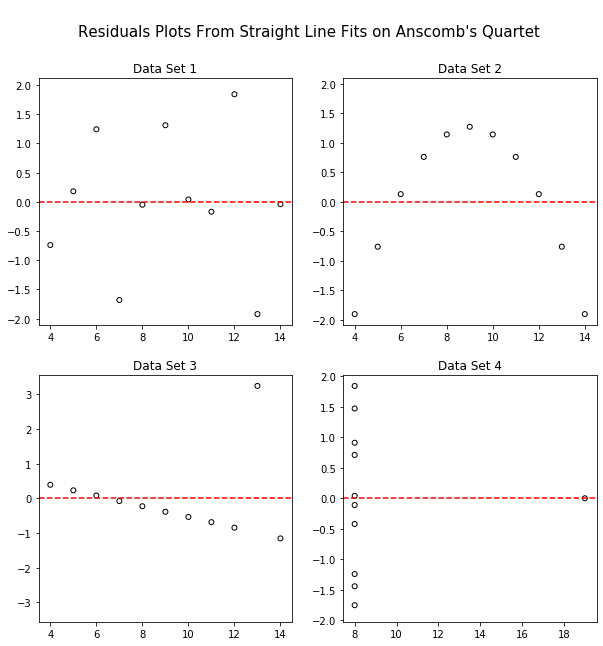

In [18]:
fig = plt.figure(figsize = (10,10))

ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 0), rowspan=1, colspan=1)
ax4 = plt.subplot2grid((2, 2), (1, 1), rowspan=1, colspan=1)

ylim = max(abs(anscombs['residuals1'].max()),abs(anscombs['residuals1'].min()))*1.10
ax1.scatter(anscombs['x1'], anscombs['residuals1'], color = 'black', s = 25, facecolors='none', edgecolors='black')
ax1.axhline(y=0, linestyle = '--', color = 'red')
ax1.set_ylim(-ylim, ylim)
ax1.set_title('Data Set 1')

ylim = max(abs(anscombs['residuals2'].max()),abs(anscombs['residuals2'].min()))*1.10
ax2.scatter(anscombs['x2'], anscombs['residuals2'], color = 'black', s = 25, facecolors='none', edgecolors='black')
ax2.axhline(y=0, linestyle = '--', color = 'red')
ax2.set_ylim(-ylim, ylim)
ax2.set_title('Data Set 2')

ylim = max(abs(anscombs['residuals3'].max()),abs(anscombs['residuals3'].min()))*1.10
ax3.scatter(anscombs['x3'], anscombs['residuals3'], color = 'black', s = 25, facecolors='none', edgecolors='black')
ax3.axhline(y=0, linestyle = '--', color = 'red')
ax3.set_ylim(-ylim, ylim)
ax3.set_title('Data Set 3')

ylim = max(abs(anscombs['residuals4'].max()),abs(anscombs['residuals4'].min()))*1.10
ax4.scatter(anscombs['x4'], anscombs['residuals4'], color = 'black', s = 25, facecolors='none', edgecolors='black')
ax4.axhline(y=0, linestyle = '--', color = 'red')
ax4.set_ylim(-ylim, ylim)
ax4.set_title('Data Set 4')

plt.suptitle("\nResiduals Plots From Straight Line Fits on Anscomb's Quartet", fontsize = 15)
plt.show()


<b>A straight‐line regression model is appropriate only for Data Set 1, since the residuals produce a random pattern.</b> On the other hand, the data in Data Set 2 seem to have a curved rather than a straight‐line relationship, since the residuals show a curved pattern. The third data set has an extreme outlier that should be investigated.

# Leverage Points

- Data points which exercise considerable influence on the fitted model are called <b>leverage points</b>.
- To make things as simple as possible, we shall begin somewhat unrealistically, by describing leverage points as either “good” or “bad."

### Good Leverage Point

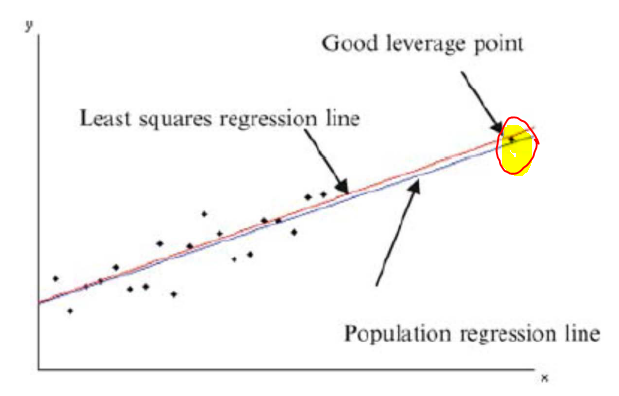

### Bad Leverage Point!
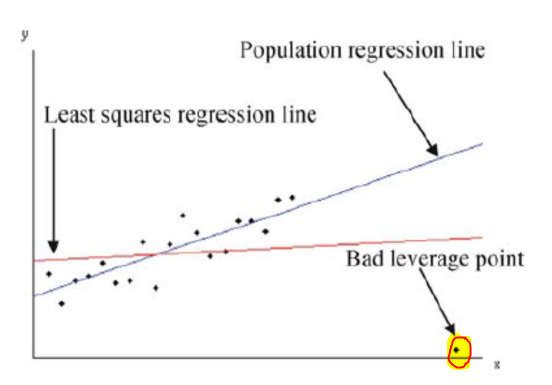

We focus on the point with the largest x‐value. Dragging this point vertically down (so that its x‐value stays the same) produces the results shown here. Notice how in the least squares regression has changed dramatically in response to changing the Y value of just a single point. The least squares regression line has been levered down by single point. Hence we call this point a leverage point. It is a bad leverage point since its Y‐value does not follow the pattern set by the other 19 points

- In summary, a leverage point is a point whose x‐value is distant from the other xvalues.
- A point is a bad leverage point if its Y‐value does not follow the pattern set by the other data points. In other words, a bad leverage point is a leverage point which is also an outlier.

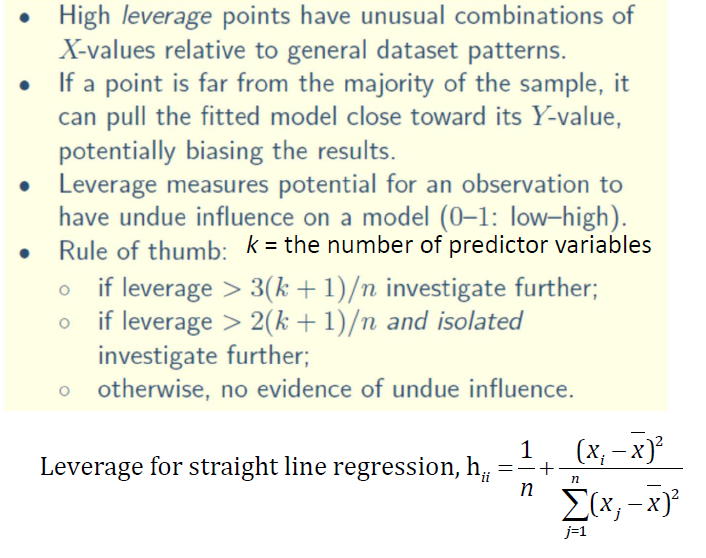

## Calculating Leverage -- Back to the college football attendance data

#### Get the College Football Data

In [19]:
if os.path.exists('./football_stats.pkl'):
    football_stats = pd.read_pickle('./football_stats.pkl')
    print("Yay! It's there!")

else:
    football_stats = get_football_attendance_data()
print('Length of the dataset is ', len(football_stats))
football_stats.head(10)

Yay! It's there!
Length of the dataset is  118


,School,2014 Home Games,2014 Attendance,2014 Average Attendance,2015 Home Games,2015 Attendance,2015 Average Attendance
0,Air Force,6,168967,28161,6,156158,26026
1,Akron,6,55019,9170,6,108588,18098
2,Alabama,7,710736,101534,7,707786,101112
3,Arizona,7,354973,50710,6,308355,51393
4,Arizona St.,6,343073,57179,7,368985,52712
5,Arkansas,6,399124,66521,7,471279,67326
6,Arkansas St.,6,149163,24861,6,138043,23007
7,Army West Point,5,171310,34262,6,185946,30991
8,Auburn,7,612157,87451,7,612157,87451
9,BYU,6,342843,57141,6,351191,58532


#### Rebuild the Old OLS Model From the Previous Lesson

In [20]:
import statsmodels.api as sm
from scipy import stats

modeling_data = football_stats.copy()

# set your X variable, also called the explanatory variable
X = modeling_data['2014 Average Attendance']

# set the Y variable, also called the dependent variable
Y = modeling_data['2015 Average Attendance']

# in StatsModels you have to add a constant
X = sm.add_constant(X) # adding a constant

# fit the model and make the predicitons
model = sm.OLS(Y, X)

# fit the model
fitted = model.fit()

# make predictions
y_hat = fitted.predict(X) 

# put predictions into the modeling dataframe
modeling_data['y_hat'] = y_hat

# mean value of X
mean_x = modeling_data['2014 Average Attendance'].mean()

# calculate predictions
y_err = Y - y_hat

# put the residual errors into the modeling dataframe
modeling_data['y_err'] = y_err

# number of values
n = len(X)

# degrees of freedom
dof = n - fitted.df_model - 1

# t-stat
t = stats.t.ppf(1-0.025, df=dof)

# standard error
s_err = np.sum(np.power(y_err, 2))

# confidence
x = X
conf = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((x-mean_x),2) / ((np.sum(np.power(x,2))) - n*(np.power(x,2))))))
conf = conf.iloc[:,1]

# set confidence into the dataframe
modeling_data['confidence'] = conf

# put the upper and lower CI into the modeling dataframe
modeling_data['upper_ci'] = modeling_data['y_hat'] + modeling_data['confidence'].abs()
modeling_data['lower_ci'] = modeling_data['y_hat'] - modeling_data['confidence'].abs()

# set the prediction intervals
from statsmodels.sandbox.regression.predstd import wls_prediction_std

sdev, lower, upper = wls_prediction_std(fitted, exog=X, alpha=0.05)

# set the prediction interverals into the dataframe
modeling_data['upper_pi'] = upper
modeling_data['lower_pi'] = lower

modeling_data

,School,2014 Home Games,2014 Attendance,2014 Average Attendance,2015 Home Games,2015 Attendance,2015 Average Attendance,y_hat,y_err,confidence,upper_ci,lower_ci,upper_pi,lower_pi
0,Air Force,6,168967,28161,6,156158,26026,28014.920137,-1988.920137,811.207924,28826.128061,27203.712213,36365.780599,19664.059675
1,Akron,6,55019,9170,6,108588,18098,9261.961884,8836.038116,926.615008,10188.576892,8335.346877,17661.047162,862.876606
2,Alabama,7,710736,101534,7,707786,101112,100468.229908,643.770092,571.367588,101039.597496,99896.862321,108987.976551,91948.483266
3,Arizona,7,354973,50710,6,308355,51393,50281.280815,1111.719185,318.976677,50600.257492,49962.304138,58624.117407,41938.444223
4,Arizona St.,6,343073,57179,7,368985,52712,56669.195455,-3957.195455,654.509623,57323.705078,56014.685833,65019.636149,48318.754762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,Washington,7,451555,64508,7,433432,61919,63906.330468,-1987.330468,647.436505,64553.766974,63258.893963,72270.704718,55541.956219
114,Washington St.,6,184762,30794,6,176444,29407,30614.916929,-1207.916929,799.334064,31414.250993,29815.582865,38962.074222,22267.759636
115,West Virginia,6,340117,56686,7,383779,54826,56182.374939,-1356.374939,653.848753,56836.223693,55528.526186,64532.080956,47832.668923
116,Western Ky.,6,97833,16306,6,107759,17960,16308.516046,1651.483954,876.639581,17185.155628,15431.876465,24685.065871,7931.966222


## Leverage - 'h'

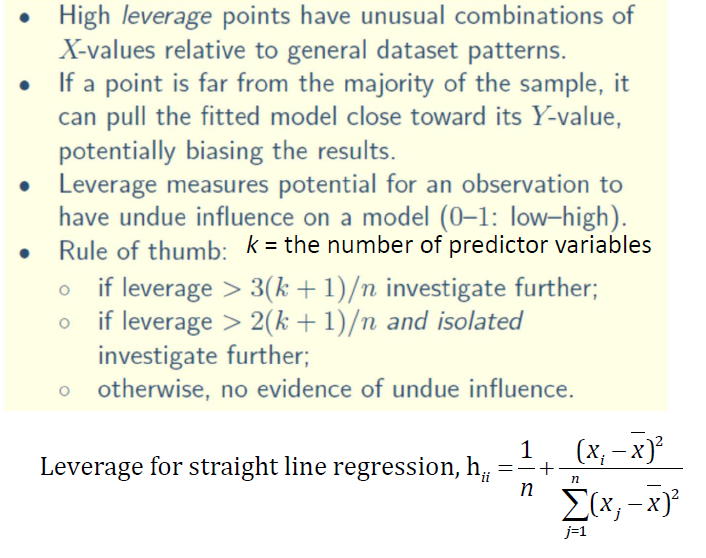

### Code to get the leverage values 'h' from the forumula above.

In [22]:
# code to get the influence data:  use the get_influence function on the fitted model.
influence = fitted.get_influence()
influence

In [23]:
# code to get the influence data:  use the get_influence function on the fitted model.
influence = fitted.get_influence()

# obtain the leverage 'h' as an array from the influence data
leverage = influence.hat_matrix_diag

# put the values in a dataframe
modeling_data['h'] = leverage

In [24]:
# find the cuttoff point

k =  1
n = len(modeling_data)
cuttoff = 3*(k+1)/n 
print(cuttoff)

0.05084745762711865


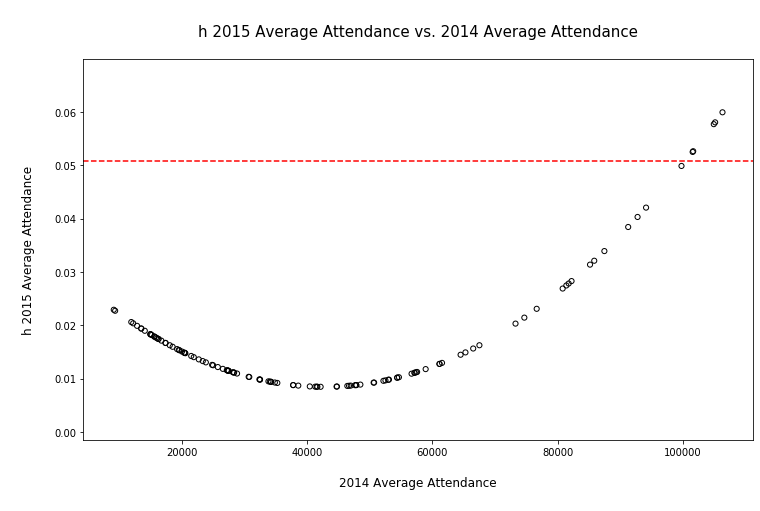

In [26]:
plt.figure(figsize = (12,7))
plt.scatter(modeling_data['2014 Average Attendance'], modeling_data['h'], s = 26,  facecolors='none', edgecolors='black')
plt.title('\nh 2015 Average Attendance vs. 2014 Average Attendance\n', fontsize = 15)
plt.axhline(y = cuttoff, linestyle = '--', color = 'red' )
plt.xlabel('\n2014 Average Attendance\n', fontsize = 12, color = 'black')
plt.ylabel('\nh 2015 Average Attendance\n', fontsize = 12, color = 'black')
plt.show()

<b><i>We see from the plot of leverage vs x that there are 5 points with leverage greater than the cut off of 3(k+1)/n = 6/118 = 0.0508.</b></i>

#### How can we find the values that are above the leverage cuttoff?

In [27]:
modeling_data.loc[modeling_data['h']>cuttoff]

,School,2014 Home Games,2014 Attendance,2014 Average Attendance,2015 Home Games,2015 Attendance,2015 Average Attendance,y_hat,y_err,confidence,upper_ci,lower_ci,upper_pi,lower_pi,h
2,Alabama,7,710736,101534,7,707786,101112,100468.229908,643.770092,571.367588,101039.597496,99896.862321,108987.976551,91948.483266,0.052529
54,Michigan,7,734364,104909,7,771174,110168,103800.926138,6367.073862,565.310788,104366.236926,103235.615350,112341.729496,95260.122780,0.057739
72,Ohio St.,7,744075,106296,7,750705,107244,105170.540856,2073.459144,562.872339,105733.413195,104607.668516,113720.322982,96620.758729,0.059964
78,Penn St.,7,711358,101623,7,698590,99799,100556.114342,-757.114342,571.205592,101127.319934,99984.908750,109076.401807,92035.826877,0.052663
97,Texas A&M,6,630735,105123,7,725354,103622,104012.243766,-390.243766,564.932656,104577.176422,103447.311110,112554.420129,95470.067403,0.058079


# Strategies for dealing with "bad" leverage point

- Remove/ correct invalid data points
    - Question the validity of the data points corresponding to bad leverage points. For example, drivers seeking auto insurance with Age = 0 (i.e. date of birth = today’s date).
- Fit a different regression model
    - Question the validity of the regression model that has been fitted, that is: <b>Has an incorrect model been fitted to the data?</b> If so, consider trying a different model by including extra predictor variables or by transforming Y and/or X. For example, adding a variable to take account of the effects of Hurricane Sandy.

# Studentized Residuals
- Thus far we have discussed the use of residuals to detect any problems with the proposed model. However, there is a complication that we need to consider, namely, that <b>residuals do not have the same variance.</b>
- This problem is overcome by considering a <b>studentized residual</b>, which is the residualdivided by its standard error.

### Code to get Studentized Residuals

In [28]:
# code to get studentized residuals
student_resid = influence.resid_studentized_external

# place the studentized residuals in the modeling data
modeling_data['studentized_residuals'] = student_resid

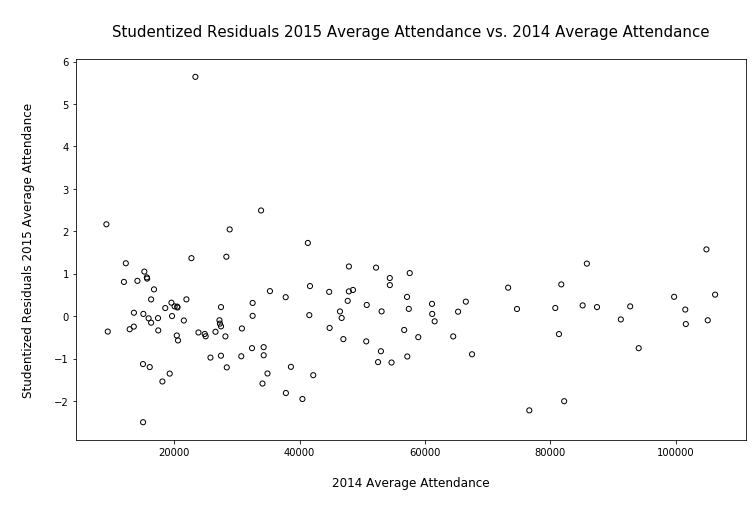

In [29]:
plt.figure(figsize = (12,7))
plt.scatter(modeling_data['2014 Average Attendance'], modeling_data['studentized_residuals'], s = 26,  facecolors='none', edgecolors='black')
plt.title('\nStudentized Residuals 2015 Average Attendance vs. 2014 Average Attendance\n', fontsize = 15)
plt.xlabel('\n2014 Average Attendance\n', fontsize = 12, color = 'black')
plt.ylabel('\nStudentized Residuals 2015 Average Attendance\n', fontsize = 12, color = 'black')
plt.show()

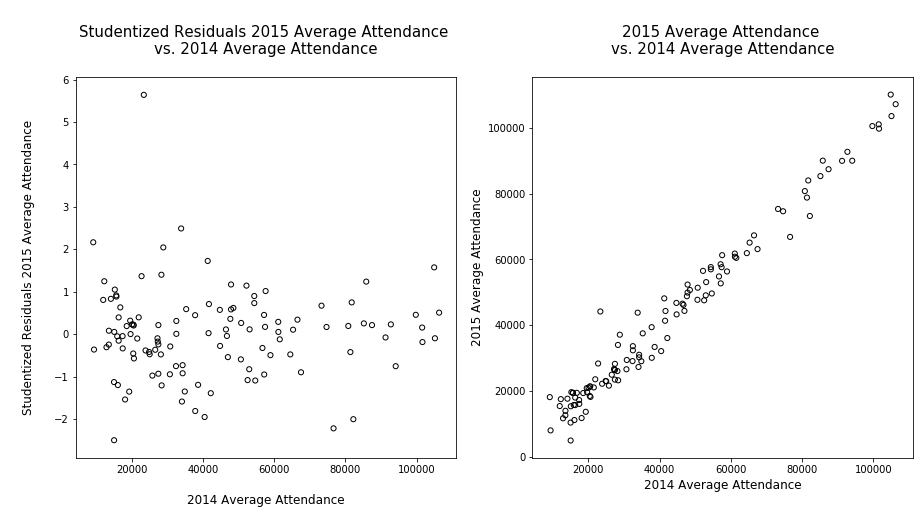

In [30]:
fig = plt.figure(figsize = (15,7))

ax1 = plt.subplot2grid((1, 2), (0, 0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), rowspan=1, colspan=1)


ax1.scatter(modeling_data['2014 Average Attendance'], modeling_data['studentized_residuals'], s = 26,  facecolors='none', edgecolors='black')
ax1.set_title('\nStudentized Residuals 2015 Average Attendance \nvs. 2014 Average Attendance\n', fontsize = 15)
ax1.set_xlabel('\n2014 Average Attendance\n', fontsize = 12, color = 'black')
ax1.set_ylabel('\nStudentized Residuals 2015 Average Attendance\n', fontsize = 12, color = 'black')

ax2.scatter(modeling_data['2014 Average Attendance'], modeling_data['2015 Average Attendance'], s = 26,  facecolors='none', edgecolors='black')
ax2.set_title('\n2015 Average Attendance \nvs. 2014 Average Attendance\n', fontsize = 15)
ax2.set_xlabel('2014 Average Attendance', fontsize = 12, color = 'black')
ax2.set_ylabel('2015 Average Attendance', fontsize = 12, color = 'black')


#plt.suptitle("\nStraight Line Fits to Anscomb's Quartet", fontsize = 15)
plt.show()

### How do we find which school is the outlier value above?

In [31]:
modeling_data.loc[modeling_data['studentized_residuals'] == modeling_data['studentized_residuals'].max()]

,School,2014 Home Games,2014 Attendance,2014 Average Attendance,2015 Home Games,2015 Attendance,2015 Average Attendance,y_hat,y_err,confidence,upper_ci,lower_ci,upper_pi,lower_pi,h,studentized_residuals
94,Temple,6,140217,23370,6,264951,44159,23283.972689,20875.027311,835.274424,24119.247113,22448.698265,31643.441539,14924.503839,0.013301,5.638287


<p>Temple's attendance almost doubled from 2014 to 2015.</p>  <p><b>According to Wikipedia:</b>  <i>"The season was highlighted by the first win against Penn State since 1941, their first ever 7–0 start, and their first AP Poll and Coaches Poll ranking since 1979, and was considered a breakout season for the program."</i>
<p>
    <b>SOURCE:  </b>https://en.wikipedia.org/wiki/2015_Temple_Owls_football_team

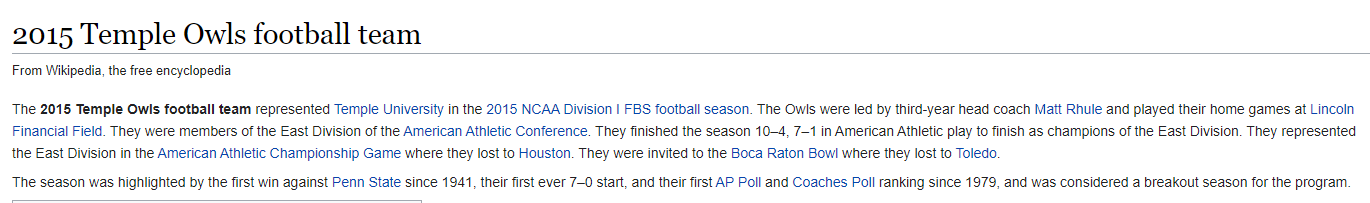

# Outliers

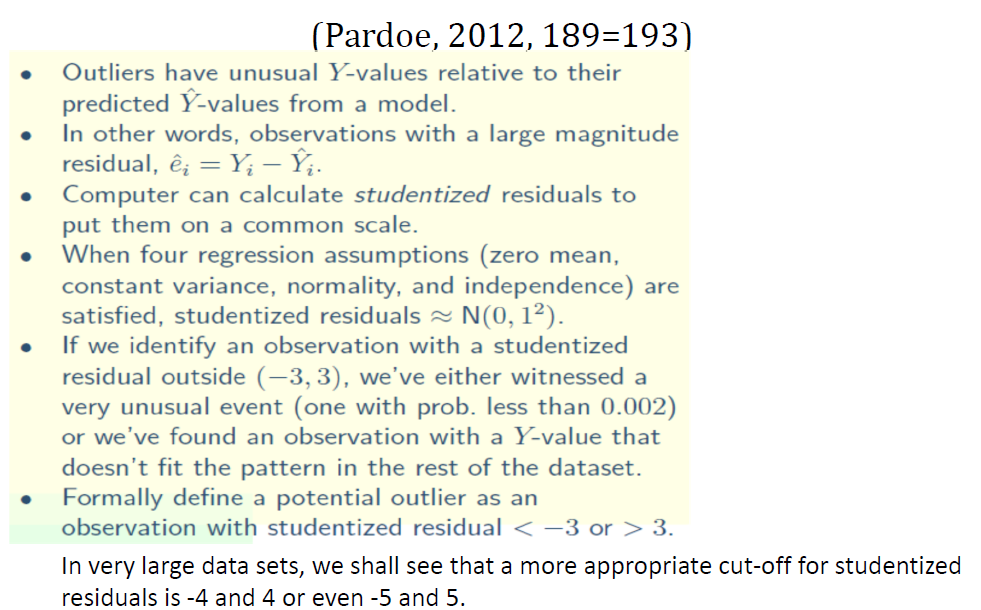

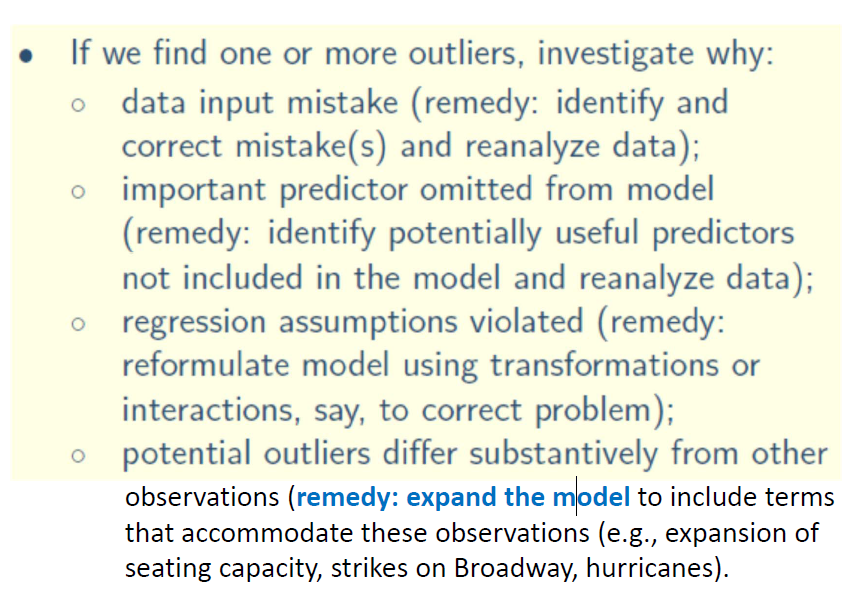

# Cook's Distance to measure "Outlyingness and Leverage" 

- Cook’s distance is a composite measure of outlyingness and leverage.
- Rule of thumb:
    - Cases with a <b>Cook’s distance > 1</b>: Deleting this case can change the regression estimates substantially and hence these cases should be thoroughly investigated.
    - Cases with a <b>Cook’s distance > 0.5</b> should also be investigated.
- Also, it is important to look for gaps in the values of Cook's distance and not just whether values exceed the suggested cutoff.
- (Cook's distance can be obtained by multiplying the square of the ith studentized residual divided by two and a function that increases as the ith leverage value increases. The first quantity measures the extent to which the ith case is outlying while the second quantity measures the leverage of the ith case.)

### Code to get Cook's Distance

In [32]:
# calculate Cook's D
(cooks,p) = influence.cooks_distance

# add Cook's D to the modeling data
modeling_data['cooks_d'] = cooks
modeling_data

,School,2014 Home Games,2014 Attendance,2014 Average Attendance,2015 Home Games,2015 Attendance,2015 Average Attendance,y_hat,y_err,confidence,upper_ci,lower_ci,upper_pi,lower_pi,h,studentized_residuals,cooks_d
0,Air Force,6,168967,28161,6,156158,26026,28014.920137,-1988.920137,811.207924,28826.128061,27203.712213,36365.780599,19664.059675,0.011215,-0.475451,0.001291
1,Akron,6,55019,9170,6,108588,18098,9261.961884,8836.038116,926.615008,10188.576892,8335.346877,17661.047162,862.876606,0.022928,2.165644,0.053331
2,Alabama,7,710736,101534,7,707786,101112,100468.229908,643.770092,571.367588,101039.597496,99896.862321,108987.976551,91948.483266,0.052529,0.157075,0.000690
3,Arizona,7,354973,50710,6,308355,51393,50281.280815,1111.719185,318.976677,50600.257492,49962.304138,58624.117407,41938.444223,0.009272,0.265316,0.000332
4,Arizona St.,6,343073,57179,7,368985,52712,56669.195455,-3957.195455,654.509623,57323.705078,56014.685833,65019.636149,48318.754762,0.011113,-0.948680,0.005061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,Washington,7,451555,64508,7,433432,61919,63906.330468,-1987.330468,647.436505,64553.766974,63258.893963,72270.704718,55541.956219,0.014490,-0.475860,0.001676
114,Washington St.,6,184762,30794,6,176444,29407,30614.916929,-1207.916929,799.334064,31414.250993,29815.582865,38962.074222,22267.759636,0.010318,-0.288442,0.000437
115,West Virginia,6,340117,56686,7,383779,54826,56182.374939,-1356.374939,653.848753,56836.223693,55528.526186,64532.080956,47832.668923,0.010935,-0.324025,0.000585
116,Western Ky.,6,97833,16306,6,107759,17960,16308.516046,1651.483954,876.639581,17185.155628,15431.876465,24685.065871,7931.966222,0.017446,0.395918,0.001402


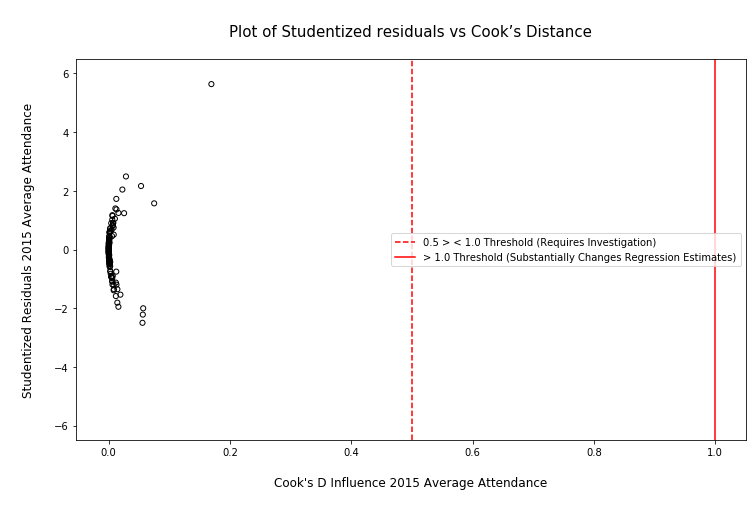

In [33]:
plt.figure(figsize = (12,7))
plt.scatter(modeling_data['cooks_d'], modeling_data['studentized_residuals'], s = 26,  facecolors='none', edgecolors='black')
plt.axvline(x = 0.5, color = 'red', linestyle = '--', label = '0.5 > < 1.0 Threshold (Requires Investigation)') #cuttoff point for cook's distance
plt.axvline(x = 1.0, color = 'red', linestyle = '-', label = '> 1.0 Threshold (Substantially Changes Regression Estimates)') #cuttoff point for cook's distance
plt.title('\nPlot of Studentized residuals vs Cook’s Distance\n', fontsize = 15)
limits = max(abs(modeling_data['studentized_residuals'].max()),abs(modeling_data['studentized_residuals'].min()))
plt.ylim(-limits*1.15, limits*1.15)
plt.xlabel("\nCook's D Influence 2015 Average Attendance\n", fontsize = 12, color = 'black')
plt.ylabel('\nStudentized Residuals 2015 Average Attendance\n', fontsize = 12, color = 'black')
plt.legend(loc = 5)
plt.show()

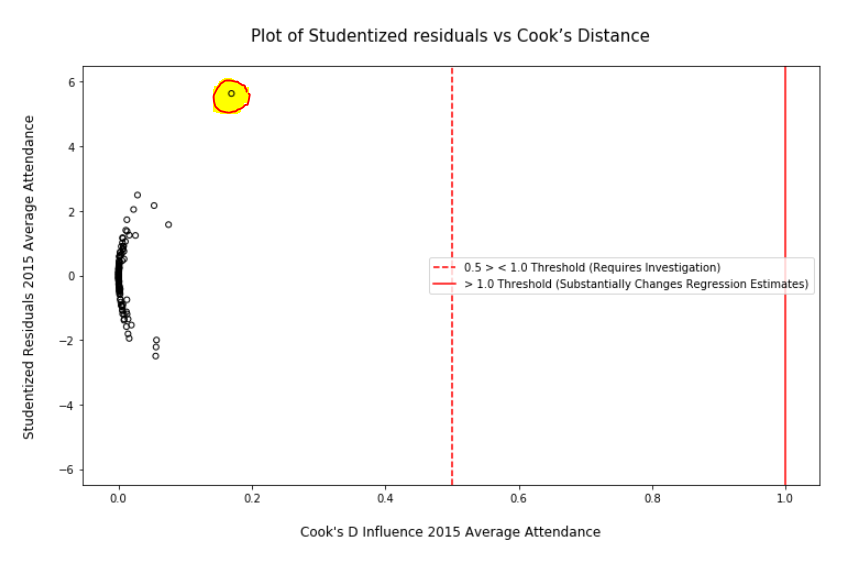

#### For good measure, we can investigate this point. 

In [139]:
 modeling_data.loc[modeling_data['cooks_d'] == modeling_data['cooks_d'].max()]

,School,2014 Home Games,2014 Attendance,2014 Average Attendance,2015 Home Games,2015 Attendance,2015 Average Attendance,y_hat,y_err,confidence,upper_ci,lower_ci,upper_pi,lower_pi,h,studentized_residuals,cooks_d
94,Temple,6,140217,23370,6,264951,44159,23283.972689,20875.027311,835.274424,24119.247113,22448.698265,31643.441539,14924.503839,0.013301,5.638287,0.169321


Temple has a Cook’s <b> distance which is < 0.5 </b>: Deleting this case is expected not to change the regression estimates substantially, even though its studentized residual is 5.15. 


Thus Temple is an <b>outlier</b> that is <b>NOT a leverage point.</b>

# Adding an Indicator Variable to Estimate the Effects of Temple's "Great Season" on the Model

Now we'll fit a model with the a variable named "Temple’s Great Season" included as an indicator variable (often called a dummy variable) This model enables us to estimate the effect of Temple’s great season on Average Attendance.

In [34]:
modeling_data["Temple's Great Season"] = 0 

In [35]:
modeling_data.head(4)

,School,2014 Home Games,2014 Attendance,2014 Average Attendance,2015 Home Games,2015 Attendance,2015 Average Attendance,y_hat,y_err,confidence,upper_ci,lower_ci,upper_pi,lower_pi,h,studentized_residuals,cooks_d,Temple's Great Season
0,Air Force,6,168967,28161,6,156158,26026,28014.920137,-1988.920137,811.207924,28826.128061,27203.712213,36365.780599,19664.059675,0.011215,-0.475451,0.001291,0
1,Akron,6,55019,9170,6,108588,18098,9261.961884,8836.038116,926.615008,10188.576892,8335.346877,17661.047162,862.876606,0.022928,2.165644,0.053331,0
2,Alabama,7,710736,101534,7,707786,101112,100468.229908,643.770092,571.367588,101039.597496,99896.862321,108987.976551,91948.483266,0.052529,0.157075,0.000690,0
3,Arizona,7,354973,50710,6,308355,51393,50281.280815,1111.719185,318.976677,50600.257492,49962.304138,58624.117407,41938.444223,0.009272,0.265316,0.000332,0


### Change the row value where temple is located to 1. 

In [36]:
# assign the row value to 1 using .loc

modeling_data.loc[modeling_data['School']=='Temple', "Temple's Great Season"] = 1

In [37]:
# view to ensure the datapoint in the cell has been changed

modeling_data.loc[modeling_data['School']=='Temple']


,School,2014 Home Games,2014 Attendance,2014 Average Attendance,2015 Home Games,2015 Attendance,2015 Average Attendance,y_hat,y_err,confidence,upper_ci,lower_ci,upper_pi,lower_pi,h,studentized_residuals,cooks_d,Temple's Great Season
94,Temple,6,140217,23370,6,264951,44159,23283.972689,20875.027311,835.274424,24119.247113,22448.698265,31643.441539,14924.503839,0.013301,5.638287,0.169321,1


In [38]:
test.loc[test['School']=='Temple']

NameError: name 'test' is not defined

### Fit the new model and compare

In [39]:
import statsmodels.api as sm
from scipy import stats

# set your X variables, also called the explanatory variables
X = modeling_data[['2014 Average Attendance', "Temple's Great Season"]]

# set the Y variable, also called the dependent variable
Y = modeling_data['2015 Average Attendance']

# in StatsModels you have to add a constant
X = sm.add_constant(X) # adding a constant

# fit the model and make the predicitons
new_model = sm.OLS(Y, X)

# fit the model
new_fitted = new_model.fit()



In [40]:
print('\n\n----------------ORIGINAL MODEL---------------\n\n')
print(fitted.summary())
print('\n\n----------------NEW MODEL---------------\n\n')
print(new_fitted.summary())



----------------ORIGINAL MODEL---------------


                               OLS Regression Results                              
Dep. Variable:     2015 Average Attendance   R-squared:                       0.974
Model:                                 OLS   Adj. R-squared:                  0.974
Method:                      Least Squares   F-statistic:                     4342.
Date:                     Tue, 08 Sep 2020   Prob (F-statistic):           9.16e-94
Time:                             10:11:59   Log-Likelihood:                -1150.7
No. Observations:                      118   AIC:                             2305.
Df Residuals:                          116   BIC:                             2311.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------

### Conclusions

<p>Fitted model with the Temple’s great season included as an indicator variable (often called a dummy variable):</p>
<p>
<b>This gives nearly the same regression parameter estimates as the model without Temple.</b>
</p>
<p>
However, in addition <b>it enables us to estimate how different the attendance at Temple is from expected (effectively using the model fit to all the other points).</b></p>

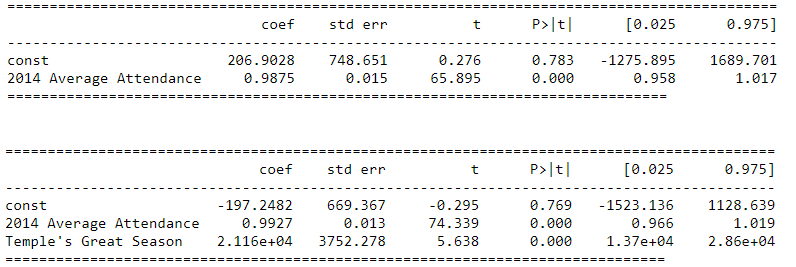

# Formula

In [67]:
x1_attendance = 23370
x2_is_good_season = 1

yhat = .9927*x1_attendance + 21160*x2_is_good_season - 197
yhat

44162.399000000005

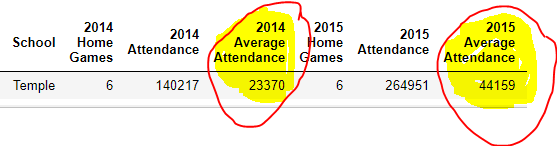